In [9]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

In [10]:
# loading the dataset
train=pd.read_csv("quora.csv")

In [11]:
#convert each question to a list of string
data = pd.Series(train["question"].tolist()).astype(str)

In [12]:
data = data[:1000]

## Text Preprocessing

In [13]:
class text_preprocessing:
    
    def __init__(self,data ):
        self.data = data
    
    def cleanhtml(self, data):    
        """ Remove any html code in the text """
        self.data = data 
        cleanr = re.compile('<.*?>')
        clean_data = re.sub(cleanr, '', data)
        return clean_data

    def tokenize_(self, data):
        """Tokenize each sentence """
        self.data = data 
        tokenized_list = []
        for d in data:
            word = nltk.word_tokenize(d)
            tokenized_list.append(word)
        return tokenized_list

    def remove_non_ascii(self, tokenized_list):
        """Remove non-ASCII characters from list of tokenized words"""
        self.tokenized_list = tokenized_list
        cleaned_list = []
        for word in tokenized_list:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            cleaned_list.append(new_word)
        return cleaned_list

    def to_lowercase(self, tokenized_list):
        """Convert all characters to lowercase from list of tokenized words"""
        self.tokenized_list = tokenized_list
        cleaned_list = []
        for word in tokenized_list:
            new_word = word.lower()
            cleaned_list.append(new_word)
        return cleaned_list

    def remove_punctuation(self, tokenized_list):
        """Remove punctuation from list of tokenized words"""
        self.tokenized_list = tokenized_list
        cleaned_list = []
        for word in tokenized_list:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                cleaned_list.append(new_word)
        return cleaned_list

    def remove_stopwords(self, tokenized_list):
        """Remove stop words from list of tokenized words"""
        self.tokenized_list = tokenized_list
        cleaned_list = []
        for word in tokenized_list:
            if word not in stopwords.words('english'):
                cleaned_list.append(word)
        return cleaned_list

    def stem_words(self, tokenized_list):
        """Stem words in list of tokenized words"""
        self.tokenized_list = tokenized_list
        stemmer = LancasterStemmer()
        stems = []
        for word in tokenized_list:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems

    def lemmatize_verbs(self, tokenized_list):
        """Lemmatize verbs in list of tokenized words"""
        self.tokenized_list = tokenized_list
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in tokenized_list:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    def remove_digits(self, word_list): 
        """ Function to remove digits from each question"""
        self.word_list = word_list
        words = []
        word_list =[i for i in word_list if  (i >= 'a' and i <= 'z') ] 
        return word_list
    
    def spell_check(self, word_list):
        """ Function to autocorrect each word in question"""
        self.word_list = word_list
        spell = SpellChecker()
        words = []
        word_list = [spell.correction(i) for i in word_list]
        return word_list

    def normalize(self, data):
        """Run all the functions for preprocessing in a pipeline"""
        self.data = data 
        clean_data = map(self.cleanhtml,data)
        tokenized_list = self.tokenize_(clean_data)
        normalized_data = []
        for i in tokenized_list:
            cleaned_list = self.remove_non_ascii(i)
            cleaned_list = self.to_lowercase(cleaned_list)
            cleaned_list = self.remove_punctuation(cleaned_list)
            cleaned_list = self.remove_stopwords(cleaned_list)
            cleaned_list = self.lemmatize_verbs(cleaned_list)
            cleaned_list = self.remove_digits(cleaned_list)
            cleaned_list = self.spell_check(cleaned_list)
            normalized_data.append(cleaned_list)
        return normalized_data


In [14]:
# Preprocess the text data
tp = text_preprocessing(data)
normalized_data = tp.normalize(data)

In [56]:
# Data after prerocessing
normalized_data 

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'use', 'vpn'],
 ['mentally', 'lonely', 'solve'],
 ['one',
  'dissolve',
  'water',
  'quickly',
  'sugar',
  'salt',
  'methane',
  'carbon',
  'di',
  'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rise', 'say'],
 ['buy', 'iago'],
 ['good', 'geologist'],
 ['use', 'instead'],
 ['motorola', 'company', 'hack', 'charter', 'motorola', 'dcx3400'],
 ['method', 'find', 'separation', 'slit', 'use', 'prestel', 'baptism'],
 ['read', 'find', 'couture', 'comment'],
 ['make', 'physics', 'easy', 'learn'],
 ['first', 'sexual', 'experience', 'like'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'green',
  'card',
  'us',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['would',
  'trump',
  'presidency',
  'mean',
  'current',
  'international',
  'master',
  'students',
  'f1',
  'visa'],
 ['manipulat

In [57]:
# function to form sentences from token
sentence = []
sentences = []


def token_2_sentence(normalized_data):
    """Join the tokens in each list with space to form a sentence"""
    for i in normalized_data:
      sentence = " ".join(i)
      sentences.append(sentence)
      sentence = [] 
    return sentences
    
sentences_list = token_2_sentence(normalized_data)

## DBSCAN with DOC2VEC

In [41]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [42]:

def tagged_document(normalized_data):
    tagged_corpus = []
    tagged_corpus = [TaggedDocument(words = d, tags=[str(i)]) for i,d in enumerate(normalized_data)]
    return tagged_corpus

In [43]:
# tagged_document(normalized_data)

In [58]:

def build_model(tagged_corpus,max_epochs,vec_size, alpha):  
    model = Doc2Vec(size=vec_size, alpha=alpha,min_alpha=0.00025, min_count=1,dm =1)
    model.build_vocab(tagged_corpus)

    for epoch in range(max_epochs):
        model.train(tagged_data,total_examples=model.corpus_count, epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha
        
    model.save("d2v.model")
    print("Model Saved")
    model_name = "d2v.model"
    return model_name


In [59]:
from gensim.models.doc2vec import Doc2Vec

def load_model(model_name, normalized_data):
    corpus_vector = []
    model= Doc2Vec.load(model_name)
    for i in range(len(normalized_data)):
        corpus_vector.append(model.infer_vector(normalized_data[i]))
    return corpus_vector

In [60]:
max_epochs = 100
vec_size = 200
alpha = 0.025

tagged_corpus =  tagged_document(normalized_data)
model_name = build_model(tagged_corpus,max_epochs,vec_size, alpha)
corpus_vector = load_model(model_name, normalized_data)                    

/home/gargi/.local/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/home/gargi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


Model Saved


In [95]:
from sklearn.decomposition import PCA

def dbscan(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.0001# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3 # the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(corpus_vector)
    print(result.shape)
    db = DBSCAN(eps=0.001, min_samples=3)
    dbscan_model = db.fit(result)
    # Forming the clusters

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels1 = dbscan_model.labels_
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
    print(labels1)
    print(len(labels1))
    print(n_clusters_) # number of clusters
    
    clusters1 = {} # a dictionary for different cluster 
    for c, i in enumerate(labels1):
        if i == -1:
            continue
        elif i in clusters1:
            clusters1[i].append( sentences[c] )
        else:
            clusters1[i] = [sentences[c]]

    for c in clusters1: # print the different clusters
        print(clusters1[c])
        print()

In [96]:
dbscan(corpus_vector)

(1000, 2)
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  1  2  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  

(1000, 2)


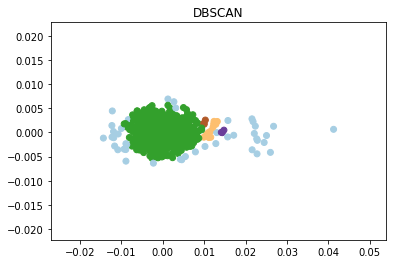

In [97]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps=0.001, min_samples=3):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan( corpus_vector,0.001, 3)